In [1]:
import warnings
warnings.filterwarnings("ignore")

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, regexp_replace
from pyspark.sql.types import IntegerType
from pyspark.sql.types import BooleanType
from pyspark.sql import Window

SparkSession.setLogLevel()

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [ ]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify Analysis").master("local").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load dataset

In [4]:
data = 'mini_sparkify_event_data.json'
df = spark.read.json(data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

## Clean Dataset

Before any analysis work, a check needs to be done to remove missing data and data that doesn't make sense.
First I will remove all rows with missing values

In [6]:
#Before any operation is made, lets record how many rows there are in the file
df.count()

286500

In [7]:
#First step is to drop rows missing userID data
df = df.dropna(how = "any", subset = ["userId"])
df.count()

286500

In [8]:
#As seen in the previous cell, no row as removed, meaning no row had missing data.
#But there is a catch: In the documentation of this data, there is stated that there is data for users who used the application before loggin in. These users appear as an empty string, as we can see below
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
# To remove them using a filter
df = df.filter(df["userId"] != "")
df.count()

278154

In [10]:
#In the next part we will explore the data and what will be explored will be detailed, but would be nice if that data would be affected by missing values in other columns, so lets check the columns
targeted_columns = ['userId', 'gender', 'level', 'location', 'page', 'registration', 'sessionId', 'ts', 'userAgent']

for target in targeted_columns:
    temp_df = df.dropna(how = "any", subset = [target])
    print(f'There are {278154 - temp_df.count()} missing in {target}')

del temp_df

There are 0 missing in userId
There are 0 missing in gender
There are 0 missing in level
There are 0 missing in location
There are 0 missing in page
There are 0 missing in registration
There are 0 missing in sessionId
There are 0 missing in ts
There are 0 missing in userAgent


In [11]:
#The conclusion is: No data was missing beyond the rows of userId == ''

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# Prepare the data for the subsequent analysis
# Before we start, we should flag the users that left the service. This will be done by creating a new boolean column in the dataset caled 'left', where True means the user has left

#Define the udf to identify and return the correct results
flag_downgrade_event = udf(lambda x: True if x == "Cancellation Confirmation" else False, BooleanType()) 

#Process the data and create the new column
df = df.withColumn("left", flag_downgrade_event("page"))


## Data Exploration

Before asking any questions, let's understand the data available. For this, lets see what each column represents

In [13]:
# First, let's see with columns the dataset has
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'left']

In [14]:
# Now lets get a sample of the data. To ease reading, the data will be converted to pandas as it renders better in a notebook
df.toPandas().head(20)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,left
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


Analyzing the data above, we can see that there are some data that can be discarded.
The first ones to go are firstName and lastName, whih represent the name of the user. With privacy protection rules around the world, analysts would typically not see such information to protect the user's privacy.

Another column to go is auth, as any usage of this service requires logging in.

Then we can also remove itemInSession and method, as they are internal data about the app.
status would be another one to go, but it might contain information about errors that the users might experience and influence on their decision to unsubscribe. So it stays.
sessionId also stays, as we can see how many times a user logs into the service

The rest are interesting information.

In [15]:
#Lets drop the columns mentioned above
df = df.drop('auth', 'firstName', 'itemInSession', 'lastName', 'method')
df.toPandas().head(5)

,artist,gender,length,level,location,page,registration,sessionId,song,status,ts,userAgent,userId,left
0,Martha Tilston,M,277.89016,paid,"Bakersfield, CA",NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,M,236.09424,free,"Boston-Cambridge-Newton, MA-NH",NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,M,282.82730,paid,"Bakersfield, CA",NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
3,Enigma,M,262.71302,free,"Boston-Cambridge-Newton, MA-NH",NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
4,Daft Punk,M,223.60771,paid,"Bakersfield, CA",NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


With the data above we can differentiate the users that downgrade to the users that stay.
But there is also a question of other activities users can do on the app. To see it more clearly, let's check the possible values of the page column

In [16]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

With the information provided with the dataset, I can't determine what every page does. So I will ask the following questions:


1. The number of artists listened
2. The number of songs listened
3. The gender
4. The location
5. How long they stay
6. How many sessions
7. How many errors with the app
8. With time is the most likely to downgrade
9. Browser
10. Device
11. level of subscription
12. What is the difference of Thumbs up between the users?
13. What is the difference of Thumbs down between the users?
14. What is the difference in the number of friends?
15. What is the difference in the number of songs added to the playlist?
16. What is the influence in looking for help?
17. What is the influence of access to settings?
18. What is the influence of ads
19. What is the difference between the time listened between the users

## Creating subsets

In [17]:
# To ease the analysis, lets create two subsets of the data. One for users which downgraded, and one


unsubbed_users = df.select(["userId"]).where(df.left == True).dropDuplicates()
unsubbed_users_list = unsubbed_users.toPandas()['userId'].tolist()
print(f'{unsubbed_users.count()} downgraded at some point') 

subscribed_users  = df.filter(~df.userId.isin(unsubbed_users_list)).select(["userId"]).dropDuplicates()
subscribed_users_list = subscribed_users.toPandas()['userId'].tolist()
print(f'{subscribed_users.count()} are currently subscribed') 

downgraded_users_df = df.filter(df.userId.isin(unsubbed_users_list))
subscribed_users_df = df.filter(df.userId.isin(subscribed_users_list))

52 downgraded at some point
173 are currently subscribed


In [18]:
52+173

225

### 1. The number of artists listened

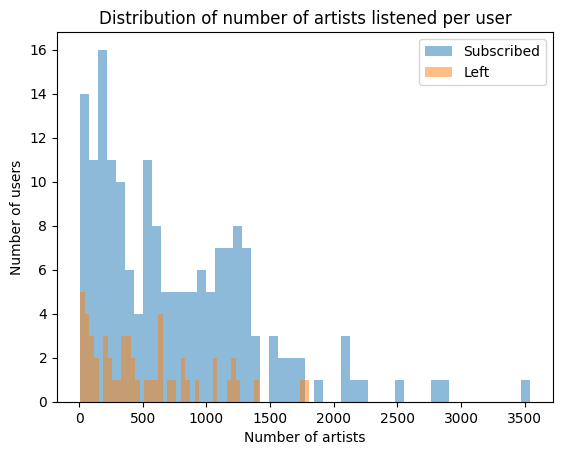

In [19]:
# Lets count one combination of artist and user using drop_duplicates, then use groupby to actually count the number of artists per user
artist_user_sb_df = subscribed_users_df.select('artist', 'userId').dropDuplicates(['artist', 'userId']).groupBy('userId').count().toPandas()
artist_user_lf_df = downgraded_users_df.select('artist', 'userId').dropDuplicates(['artist', 'userId']).groupBy('userId').count().toPandas()

# Plot as histogram
plt.hist(artist_user_sb_df['count'], 50, alpha=0.5, label='Subscribed')
plt.hist(artist_user_lf_df['count'], 50, alpha=0.5, label='Left')
plt.xlabel('Number of artists')
plt.ylabel('Number of users')
plt.title('Distribution of number of artists listened per user')
plt.legend(loc='upper right')
plt.show()


### 2. The number of songs listened

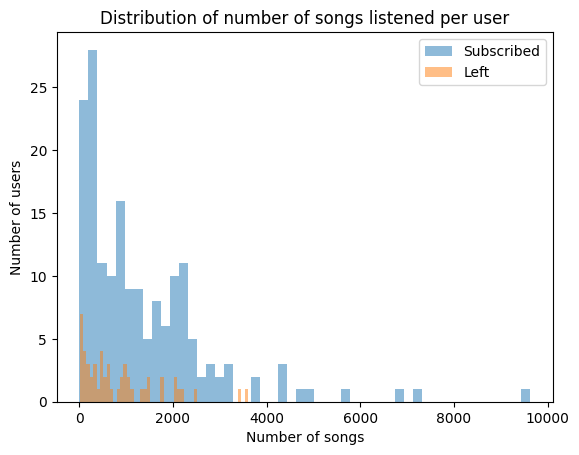

In [20]:
# The logic here is similar to the artits analysis, but many people like to listen to the same songs more than once. To account for that, dropDuplicates will not be used 
song_user_sb_df = subscribed_users_df.select('song', 'userId').groupBy('userId').count().toPandas()
song_user_lf_df = downgraded_users_df.select('song', 'userId').groupBy('userId').count().toPandas()

# Plot as histogram
plt.hist(song_user_sb_df['count'], 50, alpha=0.5, label='Subscribed')
plt.hist(song_user_lf_df['count'], 50, alpha=0.5, label='Left')
plt.xlabel('Number of songs')
plt.ylabel('Number of users')
plt.title('Distribution of number of songs listened per user')
plt.legend(loc='upper right')
plt.show()


### 3. The gender

Count of gender of subscribed users
  gender  count
0      F     84
1      M     89
Count of gender of churned users
  gender  count
0      F     20
1      M     32


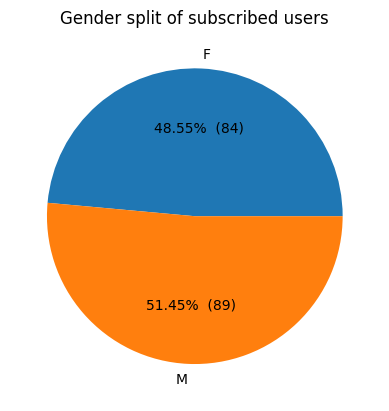

In [21]:
# Here the analysis is similar to the one for the artist, but we count the gender column, not the user one
gender_user_sb_df = subscribed_users_df.select('gender', 'userId').dropDuplicates(['userId']).groupBy('gender').count().toPandas()
gender_user_lf_df = downgraded_users_df.select('gender', 'userId').dropDuplicates(['userId']).groupBy('gender').count().toPandas()

print('Count of gender of subscribed users')
print(gender_user_sb_df.head(20))
print('Count of gender of churned users')
print(gender_user_lf_df.head(20))

# This function helps to print the labels on the pie chart
# https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    '''
    make_autopct

    Creates labels with percentage and total values to be used in charts

    Input:
    values Values to be used to create the labels

    Output:
    labels to be used in the autopct parameter of the matplotlib pie charts
    '''
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct 

# Plot a pie chart for subscribed users
plt.pie(gender_user_sb_df["count"], labels = gender_user_sb_df["gender"], autopct=make_autopct(gender_user_sb_df["count"]))
plt.title('Gender split of subscribed users')
plt.show()

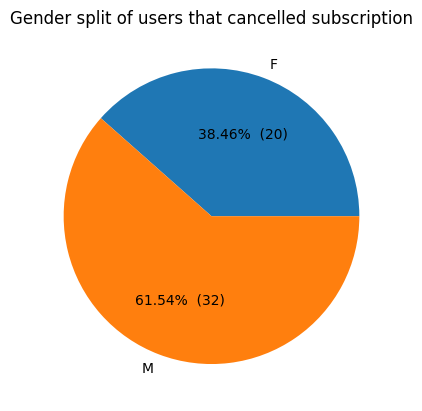

In [22]:
# Plot a pie chart for churned users
plt.pie(gender_user_lf_df["count"], labels = gender_user_lf_df["gender"], autopct=make_autopct(gender_user_lf_df["count"]))
plt.title('Gender split of users that cancelled subscription')
plt.show()

### 4. The location


Here we have two questions inside one: Where are they by city and where are they by state. I'm going to assume users dont´t change location for brevity, but it would be interesting to see if this affects the churn rate

The location column contains a string with 'City', 'State'. So I'm going to split this string and create two new columns, named city and state

<Axes: xlabel='state'>

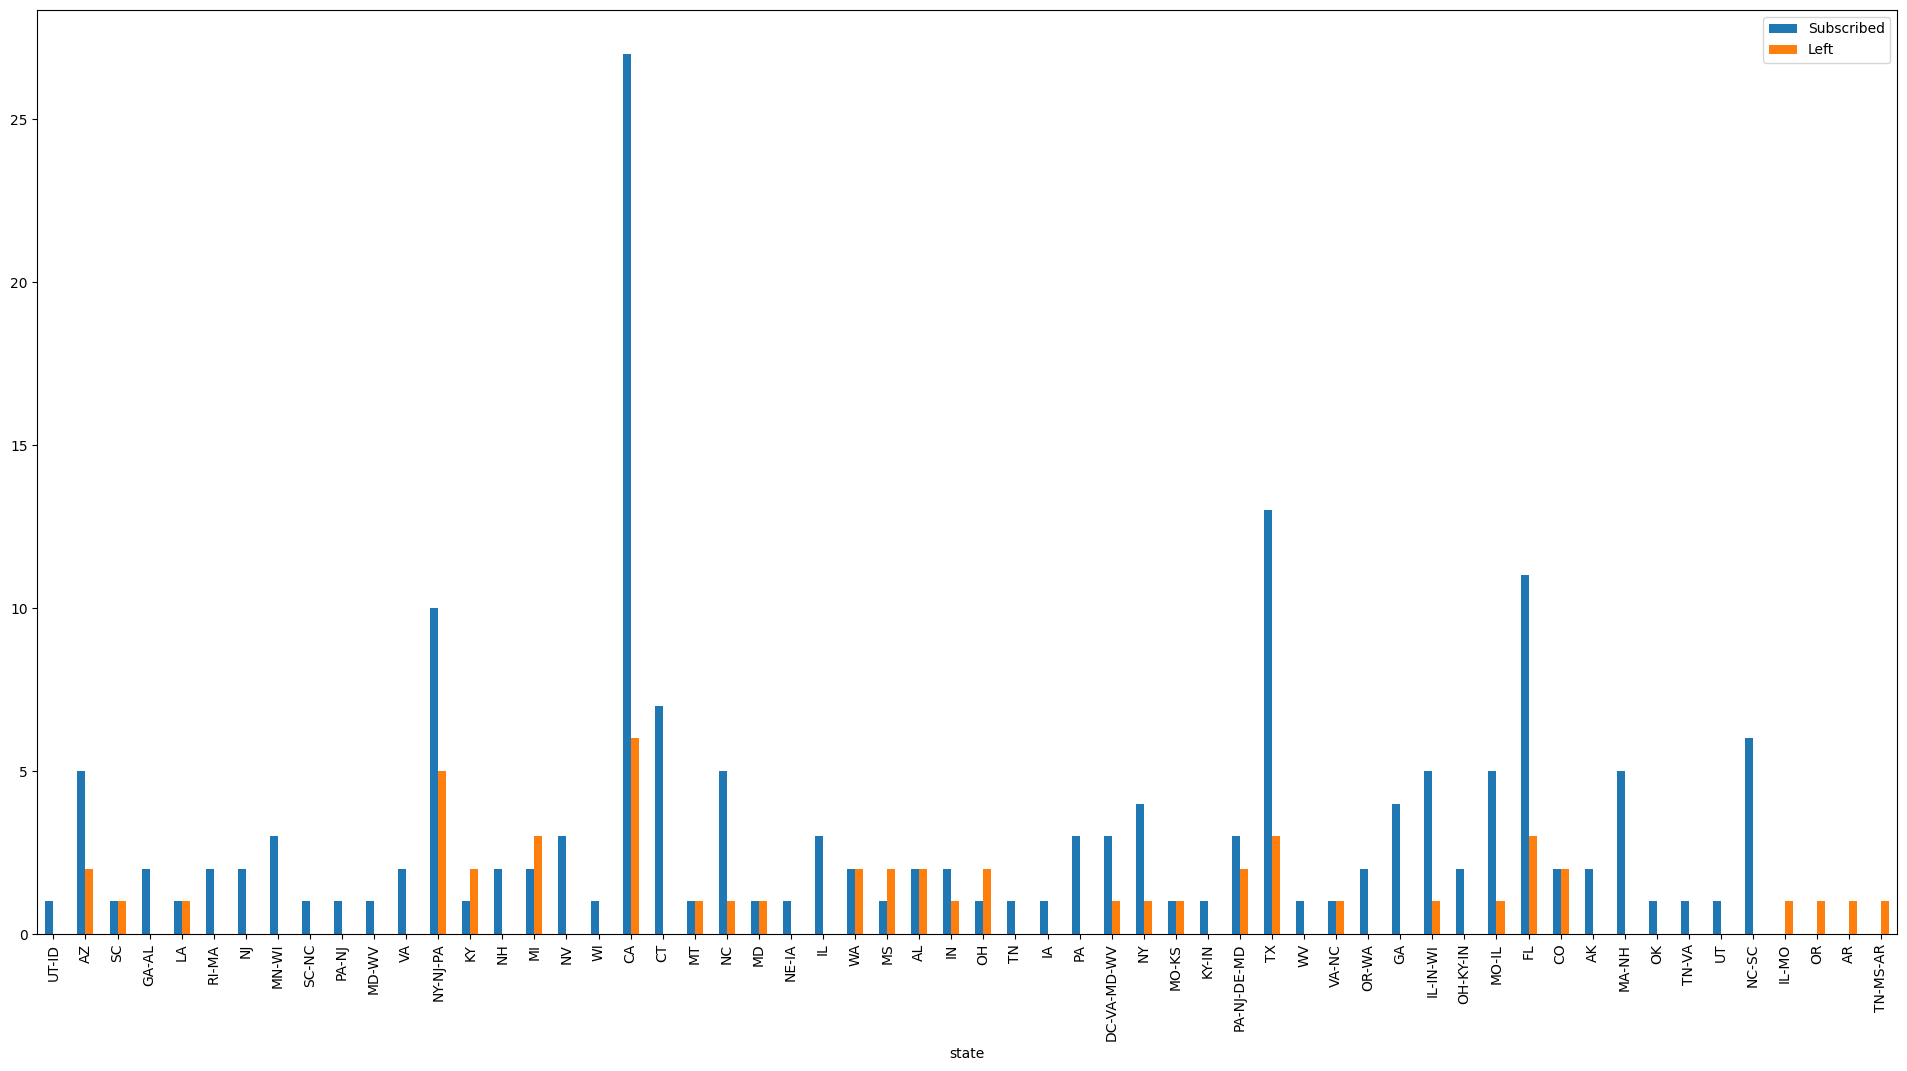

In [23]:
# To create the new columns, lets define the udfs
get_state_name = udf(lambda x: x.split(", ")[-1])
get_city_name = udf(lambda x: x.split(", ")[0])

# By State
subscribed_users_df = subscribed_users_df.withColumn("state", get_state_name("location"))
sb_by_state_df = subscribed_users_df.select('state', 'userId').dropDuplicates().groupBy('state').count().toPandas()

downgraded_users_df = downgraded_users_df.withColumn("state", get_state_name("location"))
lf_by_state_df = downgraded_users_df.select('state', 'userId').dropDuplicates().groupBy('state').count().toPandas()

df_merge = pd.merge(sb_by_state_df, lf_by_state_df, on='state', how="outer")
df_merge = df_merge.rename(columns={"count_x": "Subscribed", "count_y": "Left"})
df_merge.plot.bar(x='state', figsize=(24, 12))


<Axes: xlabel='city'>

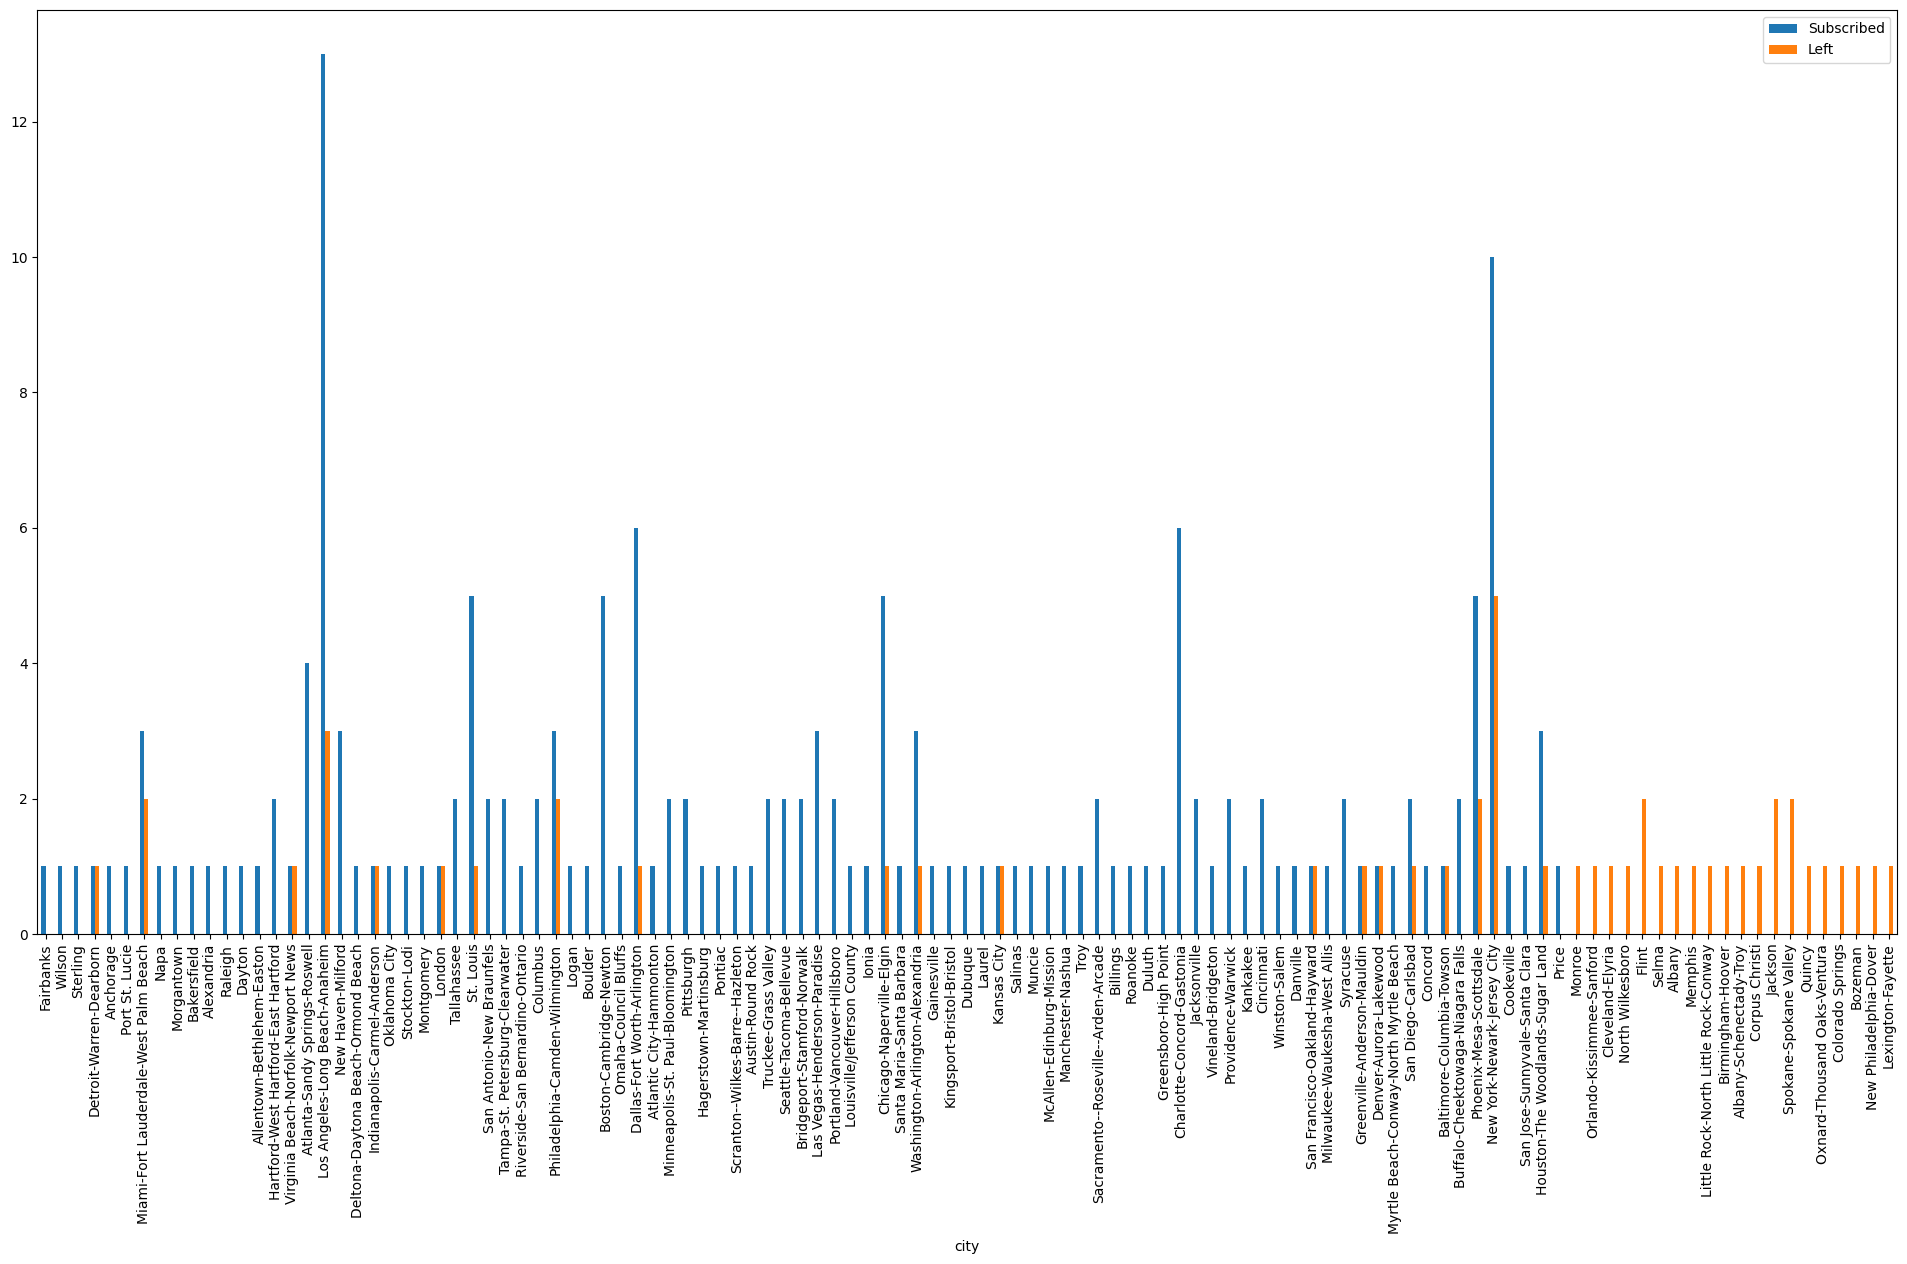

In [24]:
# By city
subscribed_users_df = subscribed_users_df.withColumn("city", get_city_name("location"))
sb_by_state_df = subscribed_users_df.select('city', 'userId').dropDuplicates().groupBy('city').count().toPandas()

downgraded_users_df = downgraded_users_df.withColumn("city", get_city_name("location"))
lf_by_state_df = downgraded_users_df.select('city', 'userId').dropDuplicates().groupBy('city').count().toPandas()

df_merge = pd.merge(sb_by_state_df, lf_by_state_df, on='city', how="outer")
df_merge = df_merge.rename(columns={"count_x": "Subscribed", "count_y": "Left"})
df_merge.plot.bar(x='city', figsize=(24, 12))

### 5. How long they stay

52


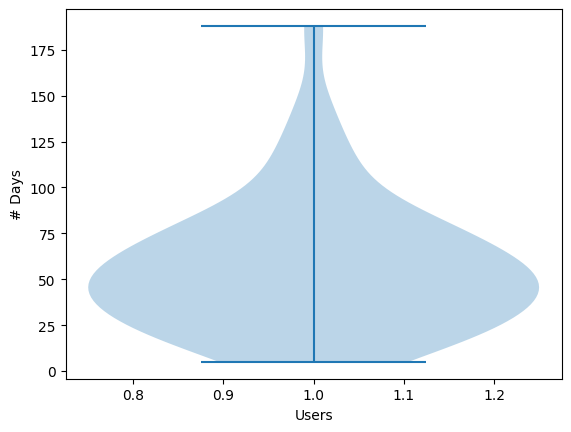

In [25]:
# Here we need to measure how long users who leave use the service. The dataset provides a registration timestamp for every user and a ts timestamp for every action.
# This metric is obtained by subtracting registration from ts
# downgrade_events_df = downgraded_users_df.select(["userId", 'registration', 'ts']).where(df.left == True).toPandas()

downgrade_events_df = downgraded_users_df.select(["userId", 'registration', 'ts']).where(df.left == True)

# Since we know 52 users left, the shape of this dataframe should contain 52 rows
print(downgrade_events_df.count())

# Calculate how long the users stayed and save the result in a new column named duration
def calculate_duration(registration, end):
    '''
    calculate_duration

    Calculates the lenght of time between registration and end and provides the result in days

    Input:
    registration    date of registration of user
    end             date when user left the service

    Output:
    Number of days of registration
    '''
    return int((end - registration)/1000/3600/24)

calculate_duration_udf = udf(calculate_duration)
downgrade_events_df = downgrade_events_df.withColumn("duration", calculate_duration_udf("registration", "ts"))

# Take a peek at the data
downgrade_events_df.head(5)

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot(list(map(int, downgrade_events_df.toPandas()['duration'].to_list())))
plt.xlabel('Users')
plt.ylabel('# Days')
plt.show()


### 6. How many sessions

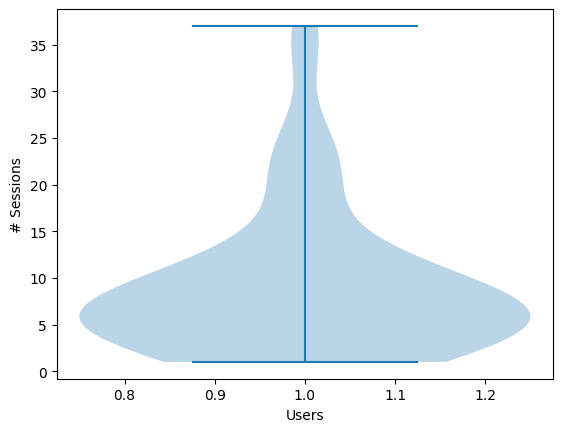

In [26]:
# This is similar to the calculation of genders, but here we calculate only for the users who left, since it is expected that users who stay to have more sessions
sessions_per_user_df = downgraded_users_df.select('sessionId', 'userId').dropDuplicates(['sessionId']).groupBy('userId').count().toPandas()
sessions_per_user_df.head()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot(sessions_per_user_df['count'].to_list())
plt.xlabel('Users')
plt.ylabel('# Sessions')
plt.show()

### 7. How many errors with the app

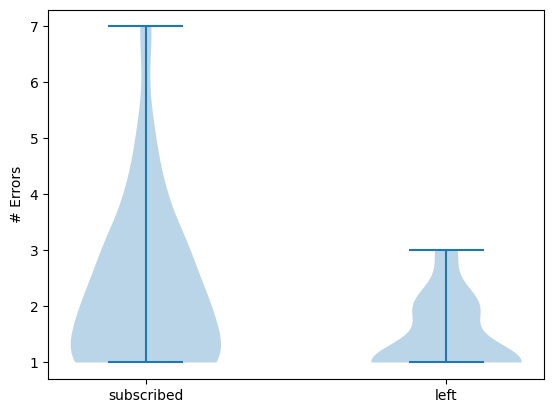

In [27]:
# Here we use the column page to measure how many times each type of user encountered errors in the platform
errors_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Error').groupBy('userId').count().toPandas()
errors_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Error').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([errors_sb_df['count'], errors_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Errors')
plt.show()


### 8. Which time is the most likely to downgrade

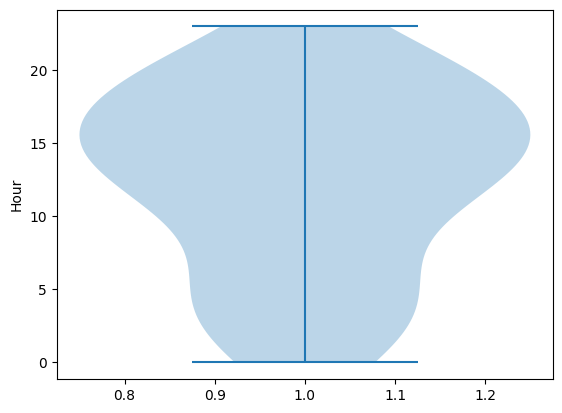

In [28]:
# To do this, first we get the timestamps of every downgrade action. With this date we then convert to a datetime object in python to obtain the hours and minutes. Finally, we plot the data
def convert_timestamp_to_hour(value):
    '''
    convert_timestamp_to_hour

    Converts datatime object of timestamp to a string containing the hour of the timestamp

    Input
    Value   timestamp

    Output
    string containing the hour of the timestamp
    '''
    date = datetime.datetime.fromtimestamp(value/1000)
    return date.strftime("%H")

convert_timestamp_to_hour_udf = udf(convert_timestamp_to_hour)
downgrade_hour_df = downgraded_users_df.withColumn("downgrade_time", convert_timestamp_to_hour_udf("ts"))

downgrade_hour_df = downgrade_hour_df.select('downgrade_time').where(downgrade_hour_df.left == True)




# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot( list(map(int, downgrade_hour_df.toPandas()['downgrade_time'].to_list() )) )
plt.ylabel('Hour')
plt.show()

### 9. Browser

In [29]:
# Lets get the data in user agent
df.select('userAgent').distinct().collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW6

   browser  count
0  Firefox     34
1   Safari    128
2    Gecko      6
3  Trident      5
   browser  count
0  Firefox     16
1   Safari     35
2    Gecko      1


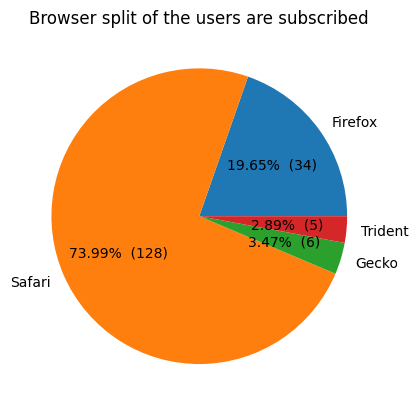

In [30]:
# To get which browser the user is using, we must look at the column userAgent, which provides strings like "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0"
# This string gives the type of browser and the device, which will be used later

# To split this string and get the type of browser, we can first split the string using spaces, then split in /

def get_browser(string):
    '''
    get_browser

    Extracts information about the browser present in the input string

    Input:
    string contains information about the device the user used to access the service

    Output:
    string containing the browser used in the access
    
    '''
    return string.split(' ')[-1].split('/')[0]

get_browser_udf = udf(get_browser)


subscribed_users_df = subscribed_users_df.withColumn("browser", get_browser_udf("userAgent"))
sb_browser_df = subscribed_users_df.select('browser', 'userId').dropDuplicates().groupBy('browser').count().toPandas()

downgraded_users_df = downgraded_users_df.withColumn("browser", get_browser_udf("userAgent"))
lf_browser_df = downgraded_users_df.select('browser', 'userId').dropDuplicates().groupBy('browser').count().toPandas()

print(sb_browser_df.head(10))
print(lf_browser_df.head(10))

plt.pie(sb_browser_df["count"], labels = sb_browser_df["browser"], autopct=make_autopct(sb_browser_df["count"]))
plt.title('Browser split of the users are subscribed')
plt.show()

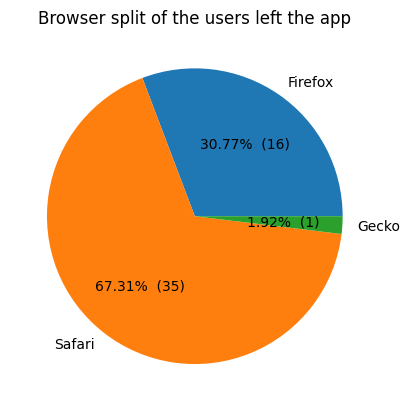

In [31]:
plt.pie(lf_browser_df["count"], labels = lf_browser_df["browser"], autopct=make_autopct(lf_browser_df["count"]))
plt.title('Browser split of the users left the app')
plt.show()

### 10. Device

       device  count
0        iPad      3
1         X11      7
2      iPhone      9
3   Macintosh     67
4  compatible      5
5     Windows     82
      device  count
0        X11      5
1     iPhone      4
2  Macintosh     19
3    Windows     24


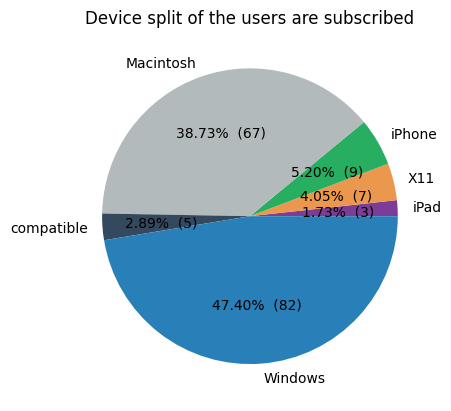

In [32]:
# As mentioned previously, the type of device can be obtained from the userAgent column.

# To split this string and get the type of device, we can first split the string using (, then split using spaces

def get_device(string):
    '''
    get_browser

    Extracts information about the device present in the input string

    Input:
    string contains information about the device the user used to access the service

    Output:
    string containing the device used in the access
    
    '''
    return string.split('(')[1].split(' ')[0].replace(';', '')

get_device_udf = udf(get_device)


subscribed_users_df = subscribed_users_df.withColumn("device", get_device_udf("userAgent"))
sb_device_df = subscribed_users_df.select('device', 'userId').dropDuplicates().groupBy('device').count().toPandas()

downgraded_users_df = downgraded_users_df.withColumn("device", get_device_udf("userAgent"))
lf_device_df = downgraded_users_df.select('device', 'userId').dropDuplicates().groupBy('device').count().toPandas()

print(sb_device_df.head(10))
print(lf_device_df.head(10))

# This dict links a device to a color, so that both graphs place the same color for the same device
colours = {'iPad': '#7d3c98',
           'X11': '#eb984e',
           'iPhone': '#27ae60',
           'Macintosh': '#b2babb',
           'compatible': '#34495e',
           'Windows': '#2980b9'}

plt.pie(sb_device_df["count"], labels = sb_device_df["device"], colors=[colours[key] for key in sb_device_df["device"]], autopct=make_autopct(sb_device_df["count"]))
plt.title('Device split of the users are subscribed')
plt.show()

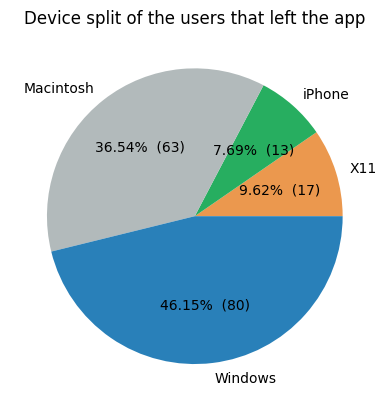

In [33]:
plt.pie(lf_device_df["count"], labels = lf_device_df["device"], colors=[colours[key] for key in lf_device_df["device"]], autopct=make_autopct(sb_device_df["count"]))
plt.title('Device split of the users that left the app')
plt.show()

### 11. level of subscription

  level  count
0  free    133
1  paid     40
  level  count
0  free     44
1  paid      8


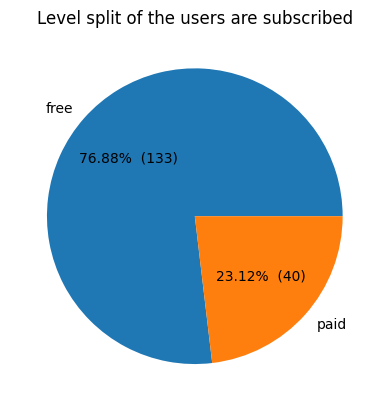

In [34]:
# On the column level we can se two distinct values: 'free' and 'paid', meaning free users (which see ads) and paid users. Let check if the type of subscription affects the outcome

#THIS MUST BE CHANGED TO ORDER BY TS DESC col('ts').desc()

level_sb_df = subscribed_users_df.select('level', 'userId').dropDuplicates(['userId']).groupBy('level').count().toPandas()
level_lf_df = downgraded_users_df.select('level', 'userId').dropDuplicates(['userId']).groupBy('level').count().toPandas()

print(level_sb_df.head(2))
print(level_lf_df.head(2))

plt.pie(level_sb_df["count"], labels = level_sb_df["level"], autopct=make_autopct(level_sb_df["count"]))
plt.title('Level split of the users are subscribed')
plt.show()

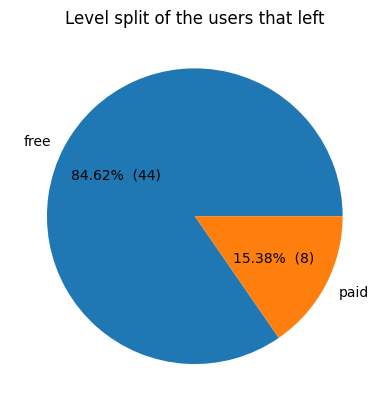

In [35]:
plt.pie(level_lf_df["count"], labels = level_lf_df["level"], autopct=make_autopct(level_lf_df["count"]))
plt.title('Level split of the users that left')
plt.show()

### 12. What is the difference of Thumbs up between the users?

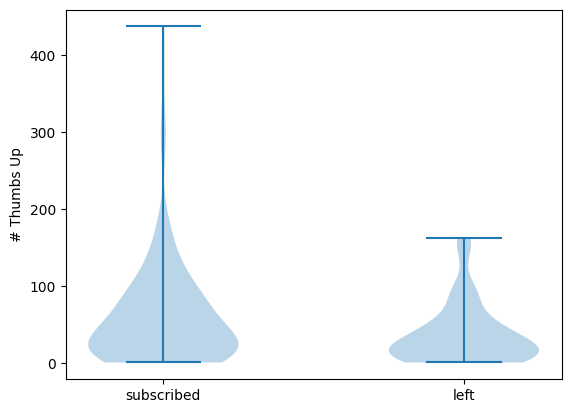

In [36]:
# Here we use the column page to measure how many times each type of user accessed the Thumbs up in the platform  Thumbs Down
tup_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Thumbs Up').groupBy('userId').count().toPandas()
tup_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Thumbs Up').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([tup_sb_df['count'], tup_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Thumbs Up')
plt.show()

### 13. What is the difference of Thumbs down between the users?

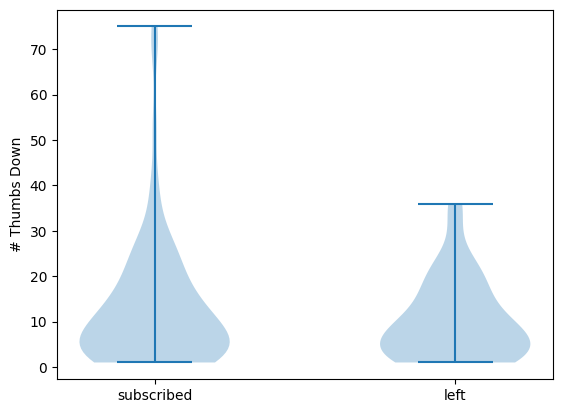

In [37]:
# The same logic of thumbs up applies
tdown_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Thumbs Down').groupBy('userId').count().toPandas()
tdown_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Thumbs Down').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([tdown_sb_df['count'], tdown_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Thumbs Down')
plt.show()

### 14. What is the difference in the number of friends?


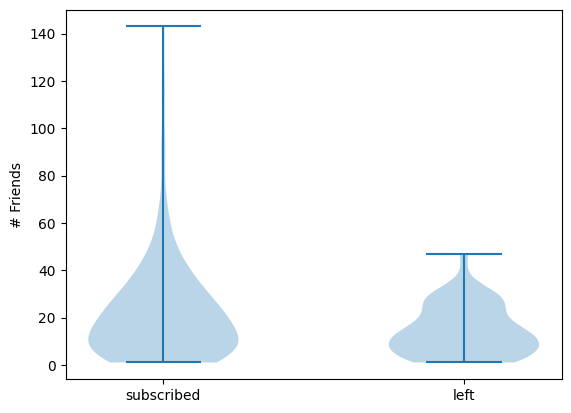

In [38]:
# Also similar to thumbs up
friends_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Add Friend').groupBy('userId').count().toPandas()
friends_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Add Friend').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([friends_sb_df['count'], friends_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Friends')
plt.show()

### 15. What is the difference in the number of songs added to the playlist?

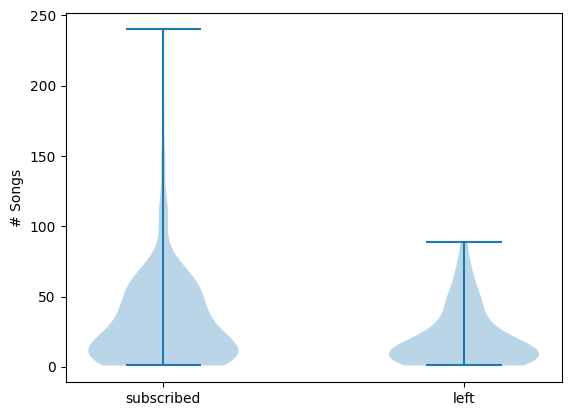

In [39]:
# Also similar to thumbs up
songspl_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Add to Playlist').groupBy('userId').count().toPandas()
songspl_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Add to Playlist').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([songspl_sb_df['count'], songspl_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Songs')
plt.show()

### 16. What is the influence in looking for help?

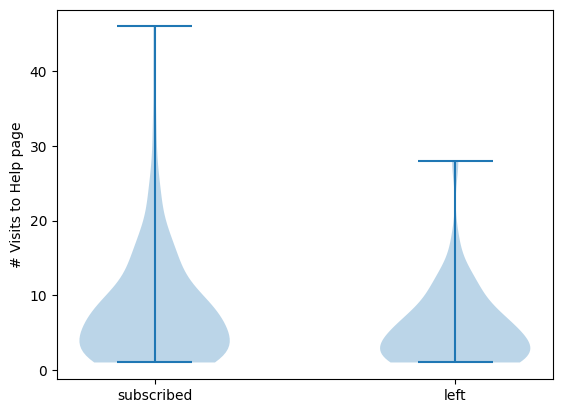

In [40]:
# Also similar to thumbs up
help_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Help').groupBy('userId').count().toPandas()
help_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Help').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([help_sb_df['count'], help_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Visits to Help page')
plt.show()

### 17. What is the influence of access to settings?

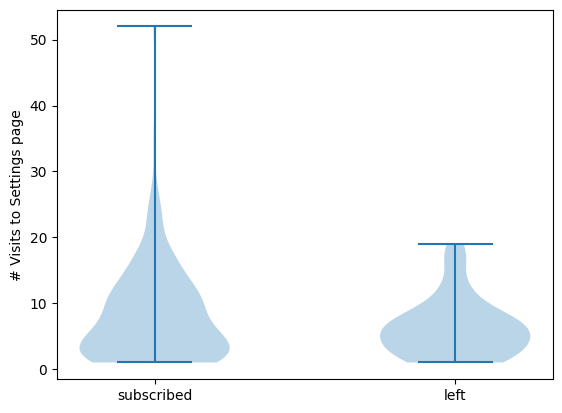

In [41]:
# Also similar to thumbs up
settings_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Settings').groupBy('userId').count().toPandas()
settings_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Settings').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([settings_sb_df['count'], settings_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Visits to Settings page')
plt.show()

### 18. What is the influence of ads

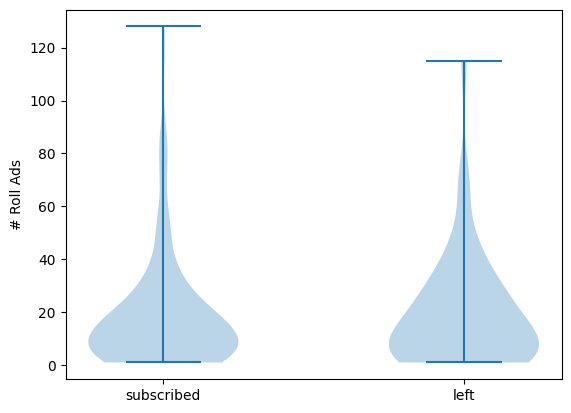

In [42]:
# Also similar to thumbs up
ad_sb_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Roll Advert').groupBy('userId').count().toPandas()
ad_lf_df = downgraded_users_df.select('page', 'userId').where(df.page == 'Roll Advert').groupBy('userId').count().toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([ad_sb_df['count'], ad_lf_df['count']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Roll Ads')
plt.show()

### 19. What is the difference between the time listened between the users

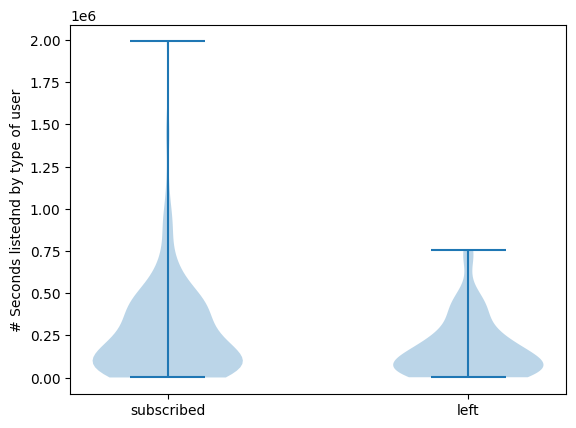

In [43]:
from pyspark.sql.functions import sum as _sum

# Here we take a look at the column lenght, which contains the lenght of each track listened to. Lets assume this unit is in seconds and every music was listened to completion
length_sb_df = subscribed_users_df.select('length', 'userId').groupBy('userId').agg(_sum('length').alias('sum_length')).toPandas()
length_lf_df = downgraded_users_df.select('length', 'userId').groupBy('userId').agg(_sum('length').alias('sum_length')).toPandas()

# Use a violin plot to display the data
fig, ax = plt.subplots()
ax.violinplot([length_sb_df['sum_length'], length_lf_df['sum_length']])
ax.set_xticks([1,2], labels=['subscribed', 'left'])
plt.ylabel('# Seconds listednd by type of user')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Criteria

With the knowledge gained with the data analysis performed above, there are variables that we could ignore. One of such examples is the thumbs down feature, which doesn't seem to change a lot between both types of user.
However, out of curiosity, I will use all of them to train the model and then check which were the most and least influential. This will prevent any bias I have to affect the model's performance will also to show how my
understanding of this problem is accurate

### Assembling the dataset

The dataset will be built with the same data above, but organized in a way where every row corresponds to a user, with how many categories and numerical values as necessary.
First I will build several small dataframes, one for each column, then merge them into one to perform scaling/normalization and the splits.

In [44]:
# Number of artists
artists_df = df.select('artist', 'userId').dropDuplicates(['artist', 'userId']).groupBy('userId').count().toPandas()
artists_df = artists_df.rename(columns={'count': 'num_artists'})

print(artists_df.shape)
artists_df.head()

(225, 2)


,userId,num_artists
0,100010,253
1,200002,340
2,125,9
3,124,2233
4,51,1386


In [45]:
# Number of songs
songs_df = df.select('song', 'userId').dropDuplicates(['song', 'userId']).groupBy('userId').count().toPandas().rename(columns={'count': 'num_songs'})

print(songs_df.shape)
songs_df.head()

(225, 2)


,userId,num_songs
0,100010,270
1,200002,379
2,125,9
3,124,3340
4,51,1855


In [46]:
# Gender
gender_df = df.select('gender', 'userId').dropDuplicates(['userId']).toPandas()

print(gender_df.shape)
gender_df.head()

(225, 2)


,gender,userId
0,M,10
1,M,100
2,F,100001
3,F,100002
4,F,100003


In [47]:
# state location
df = df.withColumn("state", get_state_name("location"))
state_df = df.select('state', 'userId').dropDuplicates(['userId']).toPandas()

print(state_df.shape)
state_df.head()

(225, 2)


,state,userId
0,MS,10
1,TX,100
2,FL,100001
3,CA,100002
4,FL,100003


In [48]:
# city localtion
df = df.withColumn("city", get_city_name("location"))
city_df = df.select('city', 'userId').dropDuplicates(['userId']).toPandas()

print(city_df.shape)
city_df.head()

(225, 2)


,city,userId
0,Laurel,10
1,Dallas-Fort Worth-Arlington,100
2,Miami-Fort Lauderdale-West Palm Beach,100001
3,Santa Maria-Santa Barbara,100002
4,Miami-Fort Lauderdale-West Palm Beach,100003


In [49]:
# Duration
duration_df = df.select(["userId", 'registration', 'ts']).orderBy(col("ts").desc()).dropDuplicates(['userId'])
duration_df = duration_df.withColumn("duration", calculate_duration_udf("registration", "ts")).toPandas()[['userId', 'duration']]

print(duration_df.shape)
duration_df.head()

(225, 2)


,userId,duration
0,100010,55
1,200002,70
2,125,71
3,124,131
4,7,72


In [50]:
# Number of sessions
sessions_df = df.select('sessionId', 'userId').dropDuplicates(['sessionId']).groupBy('userId').count().toPandas().rename(columns={'count': 'num_sessions'})

print(sessions_df.shape)
sessions_df.head()

(195, 2)


,userId,num_sessions
0,200002,1
1,100010,2
2,125,1
3,124,29
4,51,10


In [51]:
# Browser
df = df.withColumn("browser", get_browser_udf("userAgent"))
browser_df = df.select('browser', 'userId').dropDuplicates(['userId']).toPandas()

print(browser_df.shape)
browser_df.head()

(225, 2)


,browser,userId
0,Safari,10
1,Firefox,100
2,Safari,100001
3,Firefox,100002
4,Firefox,100003


In [52]:
# Device
df = df.withColumn("device", get_device_udf("userAgent"))
device_df = df.select('device', 'userId').dropDuplicates(['userId']).toPandas()

print(device_df.shape)
device_df.head()

(225, 2)


,device,userId
0,Macintosh,10
1,Windows,100
2,Macintosh,100001
3,Windows,100002
4,Windows,100003


In [53]:
# Level. Since users can change their plans, only the last entry must be collected
level_df = df.select(["userId", 'level', 'ts']).orderBy(col("ts").desc()).dropDuplicates(['userId']).toPandas()[['userId', 'level']]

print(level_df.shape)
level_df.head()

(225, 2)


,userId,level
0,10,paid
1,100,paid
2,100001,free
3,100002,paid
4,100003,free


In [54]:
# Errors
error_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Error').groupBy('userId').count().toPandas().rename(columns={'count': 'num_errors'})

print(error_df.shape)
error_df.head()

(95, 2)


,userId,num_errors
0,124,6
1,7,1
2,15,2
3,155,3
4,132,3


In [55]:
# Thumbs up
tup_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Thumbs Up').groupBy('userId').count().toPandas().rename(columns={'count': 'num_thumbsup'})

print(tup_df.shape)
tup_df.head()

(170, 2)


,userId,num_thumbsup
0,100010,17
1,200002,21
2,124,171
3,7,7
4,15,81


In [56]:
# Thumbs down
tdown_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Thumbs Down').groupBy('userId').count().toPandas().rename(columns={'count': 'num_thumbsdown'})

print(tdown_df.shape)
tdown_df.head()

(155, 2)


,userId,num_thumbsdown
0,100010,5
1,200002,6
2,124,41
3,7,1
4,15,14


In [57]:
# Number of friends
friends_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Add Friend').groupBy('userId').count().toPandas().rename(columns={'count': 'num_friends'})

print(friends_df.shape)
friends_df.head()

(162, 2)


,userId,num_friends
0,100010,4
1,200002,4
2,124,74
3,7,1
4,15,31


In [58]:
# Number of songs in playlist
songs_in_playlist_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Add to Playlist').groupBy('userId').count().toPandas().rename(columns={'count': 'num_songs_playlist'})

print(songs_in_playlist_df.shape)
songs_in_playlist_df.head()

(165, 2)


,userId,num_songs_playlist
0,100010,7
1,200002,8
2,124,118
3,7,5
4,15,59


In [59]:
# Accesses to help
help_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Help').groupBy('userId').count().toPandas().rename(columns={'count': 'num_help'})

print(help_df.shape)
help_df.head()

(149, 2)


,userId,num_help
0,100010,2
1,200002,2
2,124,23
3,7,1
4,15,8


In [60]:
# Accesses to settings
settings_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Settings').groupBy('userId').count().toPandas().rename(columns={'count': 'num_settings'})

print(settings_df.shape)
settings_df.head()

(152, 2)


,userId,num_settings
0,200002,3
1,124,20
2,7,3
3,15,16
4,155,5


In [61]:
# Number of ads
ads_df = subscribed_users_df.select('page', 'userId').where(df.page == 'Roll Advert').groupBy('userId').count().toPandas().rename(columns={'count': 'num_ads'})

print(ads_df.shape)
ads_df.head()

(157, 2)


,userId,num_ads
0,100010,52
1,200002,7
2,7,16
3,124,4
4,15,1


In [62]:
# Total time listened
length_df = df.select('length', 'userId').groupBy('userId').agg(_sum('length').alias('sum_length')).toPandas()

print(length_df.shape)
length_df.head()

(225, 2)


,userId,sum_length
0,100010,6.694090e+04
1,200002,9.400888e+04
2,125,2.089113e+03
3,51,5.232758e+05
4,124,1.012312e+06


In [63]:
# Label. Here there is also a need to order the dataset, as all users who left were previously enrolled. The order will be to order them by left desc and then drop duplicates
label_df = df.select('left', 'userId').orderBy(col("left").desc()).dropDuplicates(['userId']).toPandas()

print(label_df.shape)
label_df.head()


(225, 2)


,left,userId
0,False,100010
1,False,200002
2,True,125
3,True,51
4,False,124


As you may have noticed, some dataframes have less than 225 entries. They are fine, cause they represent a quantity and zero is a valid quantity.
The only issue is to mind this detail during the merge

### Merge

In [64]:
dataset_df = pd.merge(artists_df, songs_df, on='userId', how="outer")
dataset_df = dataset_df.merge(gender_df, on='userId', how="outer")
dataset_df = dataset_df.merge(state_df, on='userId', how="outer")
dataset_df = dataset_df.merge(city_df, on='userId', how="outer")
dataset_df = dataset_df.merge(duration_df, on='userId', how="outer")
dataset_df = dataset_df.merge(sessions_df, on='userId', how="outer")
dataset_df = dataset_df.merge(browser_df, on='userId', how="outer")
dataset_df = dataset_df.merge(device_df, on='userId', how="outer")
dataset_df = dataset_df.merge(level_df, on='userId', how="outer")
dataset_df = dataset_df.merge(error_df, on='userId', how="outer")
dataset_df = dataset_df.merge(tup_df, on='userId', how="outer")
dataset_df = dataset_df.merge(tdown_df, on='userId', how="outer")
dataset_df = dataset_df.merge(friends_df, on='userId', how="outer")
dataset_df = dataset_df.merge(help_df, on='userId', how="outer")
dataset_df = dataset_df.merge(settings_df, on='userId', how="outer")
dataset_df = dataset_df.merge(ads_df, on='userId', how="outer")
dataset_df = dataset_df.merge(length_df, on='userId', how="outer")
dataset_df = dataset_df.merge(label_df, on='userId', how="outer")
dataset_df = dataset_df.fillna(0)

pd.set_option('display.max_rows', None)
dataset_df.head()

,userId,num_artists,num_songs,gender,state,city,duration,num_sessions,browser,device,level,num_errors,num_thumbsup,num_thumbsdown,num_friends,num_help,num_settings,num_ads,sum_length,left
0,100010,253,270,F,CT,Bridgeport-Stamford-Norwalk,55,2.0,Safari,iPhone,free,0.0,17.0,5.0,4.0,2.0,0.0,52.0,6.694090e+04,False
1,200002,340,379,M,IL-IN-WI,Chicago-Naperville-Elgin,70,1.0,Safari,iPhone,paid,0.0,21.0,6.0,4.0,2.0,3.0,7.0,9.400888e+04,False
2,125,9,9,M,TX,Corpus Christi,71,1.0,Safari,Macintosh,free,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.089113e+03,True
3,124,2233,3340,F,NJ,Vineland-Bridgeton,131,29.0,Safari,Macintosh,paid,6.0,171.0,41.0,74.0,23.0,20.0,4.0,1.012312e+06,False
4,51,1386,1855,M,KY,Lexington-Fayette,19,10.0,Safari,Windows,paid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.232758e+05,True


With the dataset built, the next step is to process the variables, so they all become numeric and in a lower range.

In [65]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


categorical_columns = ['gender', 'state', 'city', 'browser', 'device', 'level', 'left']
numerical_columns = ['num_artists', 'num_songs', 'duration', 'num_sessions', 'num_errors', 'num_thumbsup', 'num_thumbsdown', 'num_friends', 'num_help', 'num_settings', 'num_ads', 'sum_length']

categorical_df = dataset_df[categorical_columns]
numerical_df = dataset_df[numerical_columns]

categorical_df = categorical_df.apply(LabelEncoder().fit_transform)
categorical_df.head(5)

,gender,state,city,browser,device,level,left
0,0,6,15,2,5,0,0
1,1,13,18,2,5,1,0
2,1,50,25,2,0,0,1
3,0,32,108,2,0,1,0
4,1,16,51,2,1,1,1


In [66]:
numerical_df_scaled = MinMaxScaler().fit_transform(numerical_df.to_numpy())
numerical_df_scaled = pd.DataFrame(numerical_df_scaled, columns=numerical_df.columns)

In [67]:
dataset_df = pd.concat([categorical_df, numerical_df_scaled], axis=1)
dataset_df.head(10)

,gender,state,city,browser,device,level,left,num_artists,num_songs,duration,num_sessions,num_errors,num_thumbsup,num_thumbsdown,num_friends,num_help,num_settings,num_ads,sum_length
0,0,6,15,2,5,0,0,0.070319,0.044759,0.214844,0.018692,0.000000,0.038902,0.066667,0.027972,0.043478,0.000000,0.406250,0.033283
1,1,13,18,2,5,1,0,0.094888,0.063099,0.273438,0.009346,0.000000,0.048055,0.080000,0.027972,0.043478,0.057692,0.054688,0.046882
2,1,50,25,2,0,0,1,0.001412,0.000841,0.277344,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000702
3,0,32,108,2,0,1,0,0.629483,0.561333,0.511719,0.271028,0.857143,0.391304,0.546667,0.517483,0.500000,0.384615,0.031250,0.508234
4,1,16,51,2,1,1,1,0.390285,0.311459,0.074219,0.093458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.262544
5,1,55,97,0,1,0,0,0.039254,0.024398,0.281250,0.065421,0.142857,0.016018,0.013333,0.006993,0.021739,0.057692,0.125000,0.018761
6,0,55,99,0,1,1,1,0.491669,0.405687,0.429688,0.345794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.357029
7,1,57,65,2,1,1,0,0.366846,0.286724,0.218750,0.140187,0.285714,0.185355,0.186667,0.216783,0.173913,0.307692,0.007812,0.239450
8,0,19,12,2,1,1,0,0.180740,0.127208,0.089844,0.056075,0.428571,0.132723,0.040000,0.076923,0.195652,0.096154,0.062500,0.099518
9,0,5,30,2,0,1,0,0.365998,0.288575,0.257812,0.149533,0.428571,0.219680,0.226667,0.286713,0.347826,0.326923,0.015625,0.242369


In [68]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
y = dataset_df['left']
X = dataset_df.drop(columns='left')

# Separate a group for testing
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

In [69]:
X_train.shape, X_test.shape

((202, 18), (23, 18))

The training dataset contains 202 entries and the test dataset contains 23

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Models to be tested

Due to hardware available and time, only six models will be tested.

- Adaboost Classifier: Tends to be strong againts overfitting and is computationaly efficient, although might have problems dealing with outliers and noise.  
- Gradient Boosting Classifier: Ensemble method that usually performs greate against missing data and also can automatically handle feature selection. On the other hand tends to be weak to overfitting and takes more time to fine tune the hyperparameters.  
- Random Forest Classifier: Combines several decision trees to produce a model that is strong against overfitting, noise and outliers, althought tends to cost more to train.  
- SVC: Effective in feature-rich datasets, is strong agains overfitting, handles both linear and non-linear tasks, but also constly to train and is sensitive to outliers.
- Logistic Regression: Simple, easy to understand and also computationally efficient, but tends to be weak against outliers and decision boundaries that are not well separated.  
- Gaussian Naive-Bayes: Simple, yet tends to perform well in datasets with many features and also performs well in small datasets. Care should be taken with it due to usage of the "naive" assumptions that the features are always independent, which might not be true in every case.


### Metrics

In this case the main metric of analysis will be the F1-score, as it tends to perform great in classification problems and with unbalanced classes, as we have here.

Accuracy, precision and recall will also be shown for curiosity, but will not be used to evaluate the final results.

### Method

All classifiers listed before will be trained using grid search, where the best estimator of each time will be saved for further analysis

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings("ignore")


seed = 42

models = [
    AdaBoostClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed,n_jobs=-1),
    SVC(random_state=seed,probability=True),
    LogisticRegression(solver='saga', multi_class='multinomial'),
    GaussianNB()
]

parameters = {
    models[0].__class__.__name__:{'n_estimators':[10, 100, 1000], 'learning_rate':[0.01, 0.001, 0.0001]},
    models[1].__class__.__name__:{'n_estimators':[10, 100, 1000], 'learning_rate':[0.01, 0.001, 0.0001]},
    models[2].__class__.__name__:{'n_estimators':[1,10,100,1000], 'min_samples_split': [2,3,4,5]},
    models[3].__class__.__name__:{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma':['scale', 'auto'], 'C': [0.001,0.01,0.1,1,10,100,1000]},
    models[4].__class__.__name__:{'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001,0.01,0.1,1,10,100,1000]},
    models[5].__class__.__name__:{'var_smoothing': np.logspace(0,-9, num=100)}

}

results = []

for model in models:
    modelname = model.__class__.__name__
    print(modelname)
    params = parameters[modelname]

    grid_pipeline = GridSearchCV(model, params)
    grid_pipeline.fit(X_train,y_train)

    acc = accuracy_score(y_test, grid_pipeline.predict(X_test))
    pre = precision_score(y_test, grid_pipeline.predict(X_test))
    rec = recall_score(y_test, grid_pipeline.predict(X_test))
    f1 = f1_score(y_test, grid_pipeline.predict(X_test))
        
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1: {:.4%}".format(f1))
    print()

    results.append(grid_pipeline)

AdaBoostClassifier


Accuracy: 100.0000%
Precision: 100.0000%
Recall: 100.0000%
F1: 100.0000%

GradientBoostingClassifier
Accuracy: 100.0000%
Precision: 100.0000%
Recall: 100.0000%
F1: 100.0000%

RandomForestClassifier
Accuracy: 100.0000%
Precision: 100.0000%
Recall: 100.0000%
F1: 100.0000%

SVC
Accuracy: 95.6522%
Precision: 85.7143%
Recall: 100.0000%
F1: 92.3077%

LogisticRegression
Accuracy: 73.9130%
Precision: 0.0000%
Recall: 0.0000%
F1: 0.0000%

GaussianNB
Accuracy: 100.0000%
Precision: 100.0000%
Recall: 100.0000%
F1: 100.0000%



In [71]:
# AdaBoostClassifier
importances_abc = results[0].best_estimator_.feature_importances_

# GradientBoostingClassifier
importances_gbc = results[1].best_estimator_.feature_importances_

# RandomForestClassifier
importances_rfc = results[2].best_estimator_.feature_importances_

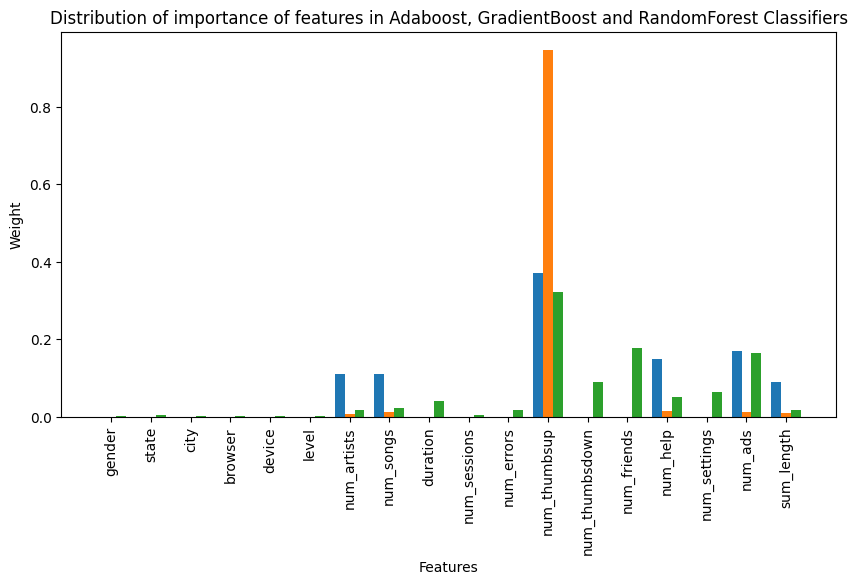

In [72]:
#features = [i for i in range(len(importances_abc))]
plt.rcParams["figure.figsize"] = (10,5)
features = np.arange(len(importances_abc))

width = 0.25

plt.bar(features-width, importances_abc, width, label = 'Ada')
plt.bar(features, importances_gbc, width, label = 'Gradient')
plt.bar(features+width, importances_rfc, width, label = 'Random')

# plt.xticks(features)
plt.xticks(features, list(X.columns), rotation=90)
plt.title('Distribution of importance of features in Adaboost, GradientBoost and RandomForest Classifiers')
plt.ylabel('Weight')
plt.xlabel('Features')

plt.show()


# Results

With the models trained, we can reach some conclusions about the best models to use in this context.

The first thing to notice is that of the six models tested, four presented a 100% result in all three metrics.
Plotting the feature importance of three of them, it can be determined that they generally agree on which features are most important, of course with some differences on what the weight should be.



# Conclusions

### On the results of the analysis

The last graph, showing the main features that each of the three models considered the most important, show a clear preference for the number of thumbsup each user has as a predictor to churn (i.e. leaving) from the service, and the following two are how many times the frequent the help page and how many times they have to roll ads. 

From a business standpoint, those should be the three points where the managers, developers and marketers should look into to understand what makes a user thumbs up a music (and maybe incentivize them to do so), to see which ads and how and when they appear, and to see what the users look up in the help page.

The same graph also shows very little importance given to gender, location and device. 
One thing that can be concluded from the location, device and help features are that any difficulties the users find while using this app is not dependent on hardware or external infrastructure (i.e. internet connection), but may indicate some inherent feature in the app. This could mean, for example, that the UI is not as intuitive.

### On the project

This was a very interesting problem to work on. While having a very close to real world application, I could also deepen my knowledge in Apache Spark, using grid search on several models and also flex my analytics muscles.

### On the next steps

This is a somewhat shallow analysis, due to the total number of users available to investigate and train a model on. In a real world case, this would only serve as a proof of concept, and an analysis of more users and more data should be used to confirm any conclusions taken here. The increased amount of data would give more confidence in the results.

Another path to improvement would be to test more classifier models, as this was limited by hardware and time to only six. More models could lead to a better trained one and also give increased support for any important features take from an analysis similar to the last graph.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.